## ℹ️ Info

* **forked original great work kernels**
    * https://www.kaggle.com/code/siddhvr/aes-2-0-deberta-lgbm-baseline
    * https://www.kaggle.com/code/olyatsimboy/5-fold-deberta-lgbm
    * https://www.kaggle.com/code/aikhmelnytskyy/quick-start-lgbm
    

* **2024/04/15 My Additional**
    * add CountVectorizer FEs.
    ```
    vectorizer_cnt = CountVectorizer(
            tokenizer=lambda x: x,
            preprocessor=lambda x: x,
            token_pattern=None,
            strip_accents='unicode',
            analyzer = 'word',
            ngram_range=(2,3),
            min_df=0.10,
            max_df=0.85,
    ```

* **2024/04/21 My Additional**
    * Add MetaFEs. Train deberta-v3-large local(5Fold SKF)
    * https://www.kaggle.com/datasets/hideyukizushi/aes2-400-20240419134941
    ```
    # CV Result
    [Fold0] 0.8358919189593519
    [Fold1] 0.8363556728124214
    [Fold2] 0.8180511976390897
    [Fold3] 0.8332431669531231
    [Fold4] 0.8331952936995911
    ```

---

In [1]:
import gc
import torch
import copy
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments,DataCollatorWithPadding
import nltk
from datasets import Dataset
from glob import glob
import numpy as np 
import pandas as pd
import polars as pl
import re
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from scipy.special import softmax
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB,MultinomialNB,ComplementNB
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.metrics import cohen_kappa_score
from lightgbm import log_evaluation, early_stopping
import lightgbm as lgb
nltk.download('wordnet')

2024-04-21 13:41:55.439737: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 13:41:55.439837: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 13:41:55.569935: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


False

In [2]:
MAX_LENGTH = 1024
TEST_DATA_PATH = "/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv"
MODEL_PATH = '/kaggle/input/aes2-400-20240419134941/*/*'
EVAL_BATCH_SIZE = 1

In [3]:
models = glob(MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained(models[0])

def tokenize(sample):
    return tokenizer(sample['full_text'], max_length=MAX_LENGTH, truncation=True)

df_test = pd.read_csv(TEST_DATA_PATH)
ds = Dataset.from_pandas(df_test).map(tokenize).remove_columns(['essay_id', 'full_text'])

args = TrainingArguments(
    ".", 
    per_device_eval_batch_size=EVAL_BATCH_SIZE, 
    report_to="none"
)

predictions = []
for model in models:
    model = AutoModelForSequenceClassification.from_pretrained(model)
    trainer = Trainer(
        model=model, 
        args=args, 
        data_collator=DataCollatorWithPadding(tokenizer), 
        tokenizer=tokenizer
    )    
    preds = trainer.predict(ds).predictions
    predictions.append(softmax(preds, axis=-1))
    del model, trainer
    torch.cuda.empty_cache()
    gc.collect()

  0%|          | 0/3 [00:00<?, ?ex/s]

In [4]:
predicted_score = 0.
for p in predictions:
    predicted_score += p
    
predicted_score /= len(predictions)

In [5]:
df_test['score'] = predicted_score.argmax(-1) + 1
df_test.head()

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,5


In [6]:
df_test[['essay_id', 'score']].to_csv('submission1.csv', index=False)

# **Data Loading**

In [7]:
columns = [  
    (
        pl.col("full_text").str.split(by="\n\n").alias("paragraph")
    ),
]
PATH = "/kaggle/input/learning-agency-lab-automated-essay-scoring-2/"

train = pl.read_csv(PATH + "train.csv").with_columns(columns)
test = pl.read_csv(PATH + "test.csv").with_columns(columns)

train.head(1)

essay_id,full_text,score,paragraph
str,str,i64,list[str]
"""000d118""","""Many people ha…",3,"[""Many people have car where they live. The thing they don't know is that when you use a car alot of thing can happen like you can get in accidet or the smoke that the car has is bad to breath on if someone is walk but in VAUBAN,Germany they dont have that proble because 70 percent of vauban's families do not own cars,and 57 percent sold a car to move there. Street parkig ,driveways and home garages are forbidden on the outskirts of freiburd that near the French and Swiss borders. You probaly won't see a car in Vauban's streets because they are completely ""car free"" but If some that lives in VAUBAN that owns a car ownership is allowed,but there are only two places that you can park a large garages at the edge of the development,where a car owner buys a space but it not cheap to buy one they sell the space for you car for $40,000 along with a home. The vauban people completed this in 2006 ,they said that this an example of a growing trend in Europe,The untile states and some where else are suburban life from auto use this is called ""smart planning"". The current efforts to drastically reduce greenhouse gas emissions from tailes the passengee cars are responsible for 12 percent of greenhouse gas emissions in Europe and up to 50 percent in some car intensive in the United States. I honeslty think that good idea that they did that is Vaudan because that makes cities denser and better for walking and in VAUBAN there are 5,500 residents within a rectangular square mile. In the artical David Gold berg said that ""All of our development since World war 2 has been centered on the cars,and that will have to change"" and i think that was very true what David Gold said because alot thing we need cars to do we can go anyway were with out cars beacuse some people are a very lazy to walk to place thats why they alot of people use car and i think that it was a good idea that that they did that in VAUBAN so people can see how we really don't need car to go to place from place because we can walk from were we need to go or we can ride bycles with out the use of a car. It good that they are doing that if you thik about your help the earth in way and thats a very good thing to. In the United states ,the Environmental protection Agency is promoting what is called ""car reduced""communtunties,and the legislators are starting to act,if cautiously. Maany experts expect pubic transport serving suburbs to play a much larger role in a new six years federal transportation bill to approved this year. In previous bill,80 percent of appropriations have by law gone to highways and only 20 percent to other transports. There many good reason why they should do this. ""]"


# **Preprocessing**

In [8]:
cList = {
  "ain't": "am not","aren't": "are not","can't": "cannot","can't've": "cannot have","'cause": "because",  "could've": "could have","couldn't": "could not","couldn't've": "could not have","didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have","hasn't": "has not",
  "haven't": "have not","he'd": "he would","he'd've": "he would have","he'll": "he will","he'll've": "he will have","he's": "he is",
  "how'd": "how did","how'd'y": "how do you","how'll": "how will","how's": "how is","I'd": "I would","I'd've": "I would have","I'll": "I will","I'll've": "I will have","I'm": "I am","I've": "I have",
  "isn't": "is not","it'd": "it had","it'd've": "it would have","it'll": "it will", "it'll've": "it will have","it's": "it is","let's": "let us","ma'am": "madam","mayn't": "may not",
  "might've": "might have","mightn't": "might not","mightn't've": "might not have","must've": "must have","mustn't": "must not","mustn't've": "must not have","needn't": "need not","needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not","oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
  "shan't've": "shall not have","she'd": "she would","she'd've": "she would have","she'll": "she will","she'll've": "she will have","she's": "she is",
  "should've": "should have","shouldn't": "should not","shouldn't've": "should not have","so've": "so have","so's": "so is","that'd": "that would","that'd've": "that would have","that's": "that is","there'd": "there had","there'd've": "there would have","there's": "there is","they'd": "they would","they'd've": "they would have","they'll": "they will","they'll've": "they will have","they're": "they are","they've": "they have","to've": "to have","wasn't": "was not","we'd": "we had",
  "we'd've": "we would have","we'll": "we will","we'll've": "we will have","we're": "we are","we've": "we have",
  "weren't": "were not","what'll": "what will","what'll've": "what will have",
  "what're": "what are","what's": "what is","what've": "what have","when's": "when is","when've": "when have",
  "where'd": "where did","where's": "where is","where've": "where have","who'll": "who will","who'll've": "who will have","who's": "who is","who've": "who have","why's": "why is",
  "why've": "why have","will've": "will have","won't": "will not","won't've": "will not have","would've": "would have","wouldn't": "would not",
  "wouldn't've": "would not have","y'all": "you all","y'alls": "you alls","y'all'd": "you all would",
  "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you had","you'd've": "you would have","you'll": "you you will","you'll've": "you you will have","you're": "you are",  "you've": "you have"
   }

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

def removeHTML(x):
    html=re.compile(r'<.*?>')
    return html.sub(r'',x)
def dataPreprocessing(x):
    x = x.lower()
    x = removeHTML(x)
    x = re.sub("@\w+", '',x)
    x = re.sub("'\d+", '',x)
    x = re.sub("\d+", '',x)
    x = re.sub("http\w+", '',x)
    x = re.sub(r"\s+", " ", x)
#     x = expandContractions(x)
    x = re.sub(r"\.+", ".", x)
    x = re.sub(r"\,+", ",", x)
    x = x.strip()
    return x

# **Feature Engineering**

### 1.Paragraph Features

In [9]:
def Paragraph_Preprocess(tmp):
    
    tmp = tmp.explode('paragraph')
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(dataPreprocessing))
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(lambda x: len(x)).alias("paragraph_len"))
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(lambda x: len(x.split('.'))).alias("paragraph_sentence_cnt"),
                    pl.col('paragraph').map_elements(lambda x: len(x.split(' '))).alias("paragraph_word_cnt"),)
    return tmp

paragraph_fea = ['paragraph_len','paragraph_sentence_cnt','paragraph_word_cnt']

def Paragraph_Eng(train_tmp):
    aggs = [
        
        *[pl.col('paragraph').filter(pl.col('paragraph_len') >= i).count().alias(f"paragraph_{i}_cnt") for i in [50,75,100,125,150,175,200,250,300,350,400,500,600,700] ], 
        *[pl.col('paragraph').filter(pl.col('paragraph_len') <= i).count().alias(f"paragraph_{i}_cnt") for i in [25,49]], 
        *[pl.col(fea).max().alias(f"{fea}_max") for fea in paragraph_fea],
        *[pl.col(fea).mean().alias(f"{fea}_mean") for fea in paragraph_fea],
        *[pl.col(fea).min().alias(f"{fea}_min") for fea in paragraph_fea],
        *[pl.col(fea).first().alias(f"{fea}_first") for fea in paragraph_fea],
        *[pl.col(fea).last().alias(f"{fea}_last") for fea in paragraph_fea],
        ]
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df
tmp = Paragraph_Preprocess(train)
train_feats = Paragraph_Eng(tmp)
train_feats['score'] = train['score']
feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Number of Features: ',len(feature_names))
train_feats.head(3)

Number of Features:  31


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,paragraph_len_min,paragraph_sentence_cnt_min,paragraph_word_cnt_min,paragraph_len_first,paragraph_sentence_cnt_first,paragraph_word_cnt_first,paragraph_len_last,paragraph_sentence_cnt_last,paragraph_word_cnt_last,score
0,000d118,1,1,1,1,1,1,1,1,1,...,2640,14,491,2640,14,491,2640,14,491,3
1,000fe60,5,5,5,5,5,5,4,3,3,...,184,3,37,184,4,37,235,3,46,3
2,001ab80,4,4,4,4,4,4,4,4,4,...,476,5,85,576,5,101,476,5,85,4


### 2.Sentence Features

In [10]:
def Sentence_Preprocess(tmp):
    tmp = tmp.with_columns(pl.col('full_text').map_elements(dataPreprocessing).str.split(by=".").alias("sentence"))
    tmp = tmp.explode('sentence')
    tmp = tmp.with_columns(pl.col('sentence').map_elements(lambda x: len(x)).alias("sentence_len"))
    tmp = tmp.filter(pl.col('sentence_len')>=15)
    tmp = tmp.with_columns(pl.col('sentence').map_elements(lambda x: len(x.split(' '))).alias("sentence_word_cnt"))
    return tmp

sentence_fea = ['sentence_len','sentence_word_cnt']
def Sentence_Eng(train_tmp):
    aggs = [
        *[pl.col('sentence').filter(pl.col('sentence_len') >= i).count().alias(f"sentence_{i}_cnt") for i in [15,50,100,150,200,250,300] ], 
        *[pl.col(fea).max().alias(f"{fea}_max") for fea in sentence_fea],
        *[pl.col(fea).mean().alias(f"{fea}_mean") for fea in sentence_fea],
        *[pl.col(fea).min().alias(f"{fea}_min") for fea in sentence_fea],
        *[pl.col(fea).first().alias(f"{fea}_first") for fea in sentence_fea],
        *[pl.col(fea).last().alias(f"{fea}_last") for fea in sentence_fea],
        ]
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df

tmp = Sentence_Preprocess(train)
train_feats = train_feats.merge(Sentence_Eng(tmp), on='essay_id', how='left')
feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Number of Features: ',len(feature_names))
train_feats.head(3)

Number of Features:  48


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,sentence_len_max,sentence_word_cnt_max,sentence_len_mean,sentence_word_cnt_mean,sentence_len_min,sentence_word_cnt_min,sentence_len_first,sentence_word_cnt_first,sentence_len_last,sentence_word_cnt_last
0,000d118,1,1,1,1,1,1,1,1,1,...,593,127,202.076923,38.692308,36,7,36,7,47,10
1,000fe60,5,5,5,5,5,5,4,3,3,...,250,49,96.823529,20.470588,27,7,62,13,124,25
2,001ab80,4,4,4,4,4,4,4,4,4,...,237,47,126.708333,23.875000,58,10,144,27,58,10


### 3.Word Features

In [11]:
def Word_Preprocess(tmp):
    tmp = tmp.with_columns(pl.col('full_text').map_elements(dataPreprocessing).str.split(by=" ").alias("word"))
    tmp = tmp.explode('word')
    tmp = tmp.with_columns(pl.col('word').map_elements(lambda x: len(x)).alias("word_len"))
    tmp = tmp.filter(pl.col('word_len')!=0)
    return tmp

def Word_Eng(train_tmp):
    aggs = [
        *[pl.col('word').filter(pl.col('word_len') >= i+1).count().alias(f"word_{i+1}_cnt") for i in range(15) ], 
        pl.col('word_len').max().alias(f"word_len_max"),
        pl.col('word_len').mean().alias(f"word_len_mean"),
        pl.col('word_len').std().alias(f"word_len_std"),
        pl.col('word_len').quantile(0.25).alias(f"word_len_q1"),
        pl.col('word_len').quantile(0.50).alias(f"word_len_q2"),
        pl.col('word_len').quantile(0.75).alias(f"word_len_q3"),
        ]
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df

tmp = Word_Preprocess(train)
train_feats = train_feats.merge(Word_Eng(tmp), on='essay_id', how='left')
feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Number of Features: ',len(feature_names))
train_feats.head(3)

Number of Features:  69


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,word_12_cnt,word_13_cnt,word_14_cnt,word_15_cnt,word_len_max,word_len_mean,word_len_std,word_len_q1,word_len_q2,word_len_q3
0,000d118,1,1,1,1,1,1,1,1,1,...,6,6,5,2,25,4.378819,2.538495,3.0,4.0,5.0
1,000fe60,5,5,5,5,5,5,4,3,3,...,0,0,0,0,11,4.012048,2.060968,2.0,4.0,5.0
2,001ab80,4,4,4,4,4,4,4,4,4,...,14,10,5,2,15,4.574545,2.604621,3.0,4.0,5.0


### 4.Tf-idf features

In [12]:
vectorizer = TfidfVectorizer(
            tokenizer=lambda x: x,
            preprocessor=lambda x: x,
            token_pattern=None,
            strip_accents='unicode',
            analyzer = 'word',
            ngram_range=(3,6),
            min_df=0.05,
            max_df=0.95,
            sublinear_tf=True,
)

train_tfid = vectorizer.fit_transform([i for i in train['full_text']])
dense_matrix = train_tfid.toarray()
df = pd.DataFrame(dense_matrix)
tfid_columns = [ f'tfid_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
df['essay_id'] = train_feats['essay_id']
train_feats = train_feats.merge(df, on='essay_id', how='left')
feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Number of Features: ',len(feature_names))
train_feats.head(3)

Number of Features:  19696


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,tfid_19617,tfid_19618,tfid_19619,tfid_19620,tfid_19621,tfid_19622,tfid_19623,tfid_19624,tfid_19625,tfid_19626
0,000d118,1,1,1,1,1,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,000fe60,5,5,5,5,5,5,4,3,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,001ab80,4,4,4,4,4,4,4,4,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 5.CountVectorizer Features

In [13]:
vectorizer_cnt = CountVectorizer(
            tokenizer=lambda x: x,
            preprocessor=lambda x: x,
            token_pattern=None,
            strip_accents='unicode',
            analyzer = 'word',
            ngram_range=(3,5),
            min_df=0.10,
            max_df=0.85,
)
train_tfid = vectorizer_cnt.fit_transform([i for i in train['full_text']])
dense_matrix = train_tfid.toarray()
df = pd.DataFrame(dense_matrix)
tfid_columns = [ f'tfid_cnt_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
df['essay_id'] = train_feats['essay_id']
train_feats = train_feats.merge(df, on='essay_id', how='left')

### 6.Meta Features(deberta-v3-large)

In [14]:
import joblib

deberta_oof = joblib.load('/kaggle/input/aes2-400-20240419134941/oof.pkl')
print(deberta_oof.shape, train_feats.shape)

for i in range(6):
    train_feats[f'deberta_oof_{i}'] = deberta_oof[:, i]

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))    

train_feats.shape

(17307, 6) (17307, 27057)
Features Number:  27061


(17307, 27063)

# **Model training**

In [15]:
def quadratic_weighted_kappa(y_true, y_pred):
    y_true = y_true + a
    y_pred = (y_pred + a).clip(1, 6).round()
    qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
    return 'QWK', qwk, True
def qwk_obj(y_true, y_pred):
    labels = y_true + a
    preds = y_pred + a
    preds = preds.clip(1, 6)
    f = 1/2*np.sum((preds-labels)**2)
    g = 1/2*np.sum((preds-a)**2+b)
    df = preds - labels
    dg = preds - a
    grad = (df/g - f*dg/g**2)*len(labels)
    hess = np.ones(len(labels))
    return grad, hess
a = 2.998
b = 1.092

In [16]:
X = train_feats[feature_names].astype(np.float32).values

y_split = train_feats['score'].astype(int).values
y = train_feats['score'].astype(np.float32).values-a
oof = train_feats['score'].astype(int).values

In [17]:
len(feature_names)

27061

# **Let's use cross-validation**

fold 1
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.828263	valid's QWK: 0.829386
[50]	train's QWK: 0.840795	valid's QWK: 0.833453
[75]	train's QWK: 0.845969	valid's QWK: 0.833988
[100]	train's QWK: 0.850427	valid's QWK: 0.833279
[125]	train's QWK: 0.855198	valid's QWK: 0.834815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[150]	train's QWK: 0.858716	valid's QWK: 0.838074
[175]	train's QWK: 0.861572	valid's QWK: 0.837643
[200]	train's QWK: 0.865221	valid's QWK: 0.837409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[225]	train's QWK: 0.8684	valid's QWK: 0.834224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[174]	train's QWK: 0.861722	valid's QWK: 0.838844
Evaluated only: QWK


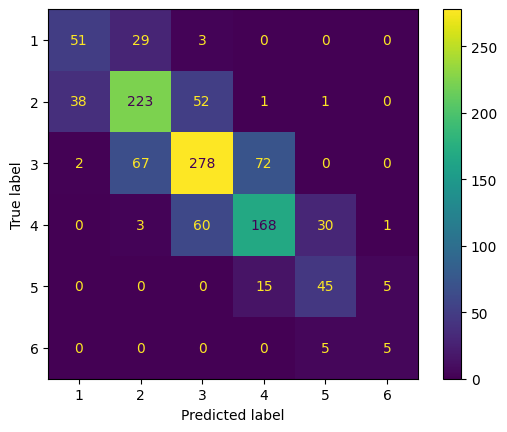

F1 score across fold: 0.6680090508269425
Cohen kappa score across fold: 0.8388439898578417
fold 2
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.827213	valid's QWK: 0.823321
[50]	train's QWK: 0.837526	valid's QWK: 0.83385
[75]	train's QWK: 0.843346	valid's QWK: 0.837065
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	train's QWK: 0.849128	valid's QWK: 0.837375
[125]	train's QWK: 0.853771	valid's QWK: 0.837619
[150]	train's QWK: 0.857684	valid's QWK: 0.837623
[175]	train's QWK: 0.861719	valid's QWK: 0.837104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	train's QWK: 0.864635	valid's QWK: 0.838278
[225]	train's QWK: 0.868455	valid's QWK: 0.840601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[250]	train's QWK: 0.8718	valid's QWK: 0.840683
[LightGBM] [Warning] No further splits with positive gain, best ga

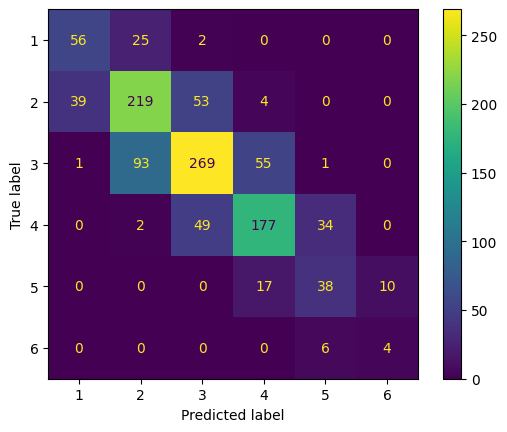

F1 score across fold: 0.6631300639447743
Cohen kappa score across fold: 0.8422644538050307
fold 3
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.825351	valid's QWK: 0.812882
[50]	train's QWK: 0.839701	valid's QWK: 0.826265
[75]	train's QWK: 0.846067	valid's QWK: 0.825764
[100]	train's QWK: 0.849888	valid's QWK: 0.825228
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[125]	train's QWK: 0.853395	valid's QWK: 0.826421
Early stopping, best iteration is:
[55]	train's QWK: 0.841401	valid's QWK: 0.829418
Evaluated only: QWK


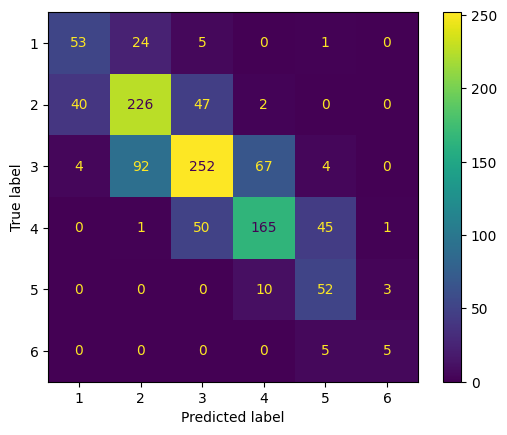

F1 score across fold: 0.6532807394892924
Cohen kappa score across fold: 0.8294177861706727
fold 4
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.829628	valid's QWK: 0.825224
[50]	train's QWK: 0.841491	valid's QWK: 0.832356
[75]	train's QWK: 0.847878	valid's QWK: 0.83109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	train's QWK: 0.851495	valid's QWK: 0.831442
[125]	train's QWK: 0.855021	valid's QWK: 0.830173
[150]	train's QWK: 0.858774	valid's QWK: 0.831115
Early stopping, best iteration is:
[85]	train's QWK: 0.849454	valid's QWK: 0.833241
Evaluated only: QWK


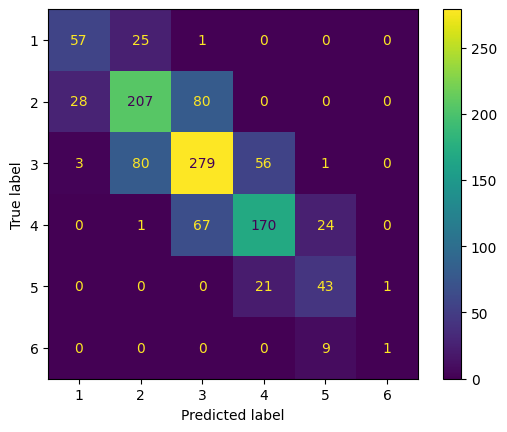

F1 score across fold: 0.6545900850626162
Cohen kappa score across fold: 0.8332405944296766
fold 5
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.828592	valid's QWK: 0.814616
[50]	train's QWK: 0.840861	valid's QWK: 0.821073
[75]	train's QWK: 0.845569	valid's QWK: 0.821918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	train's QWK: 0.850843	valid's QWK: 0.825886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[125]	train's QWK: 0.854154	valid's QWK: 0.82365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[150]	train's QWK: 0.858141	valid's QWK: 0.821812
Early stopping, best iteration is:
[90]	train's QWK: 0.848973	valid's QWK: 0.826648
Evaluated only: QWK


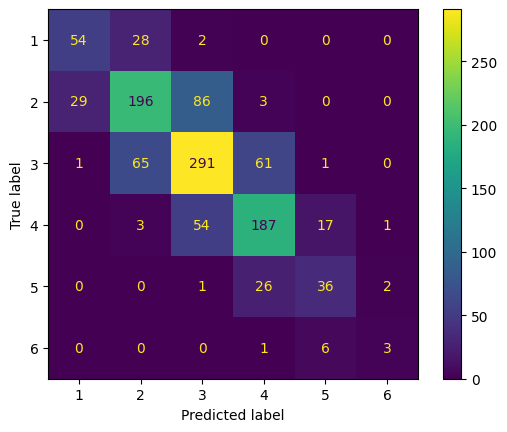

F1 score across fold: 0.6634727361491844
Cohen kappa score across fold: 0.8266477847346915
fold 6
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.829033	valid's QWK: 0.831409
[50]	train's QWK: 0.840978	valid's QWK: 0.842165
[75]	train's QWK: 0.846237	valid's QWK: 0.844812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	train's QWK: 0.850271	valid's QWK: 0.845752
[125]	train's QWK: 0.853612	valid's QWK: 0.845629
[150]	train's QWK: 0.856544	valid's QWK: 0.848004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[175]	train's QWK: 0.859935	valid's QWK: 0.849938
[200]	train's QWK: 0.863315	valid's QWK: 0.851228
[225]	train's QWK: 0.866769	valid's QWK: 0.850333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[250]	train's QWK: 0.869282	valid's QWK: 0.849291
[LightGBM] [Warning] No further splits with positive gain, best

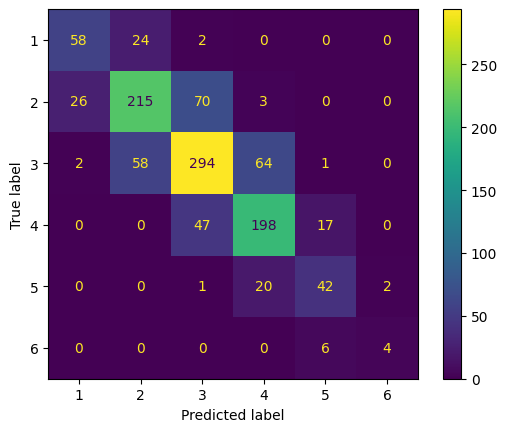

F1 score across fold: 0.7022689147714724
Cohen kappa score across fold: 0.8521457530254404
fold 7
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.830986	valid's QWK: 0.809796
[50]	train's QWK: 0.842624	valid's QWK: 0.822591
[75]	train's QWK: 0.848202	valid's QWK: 0.826794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	train's QWK: 0.851974	valid's QWK: 0.826177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[125]	train's QWK: 0.855431	valid's QWK: 0.828678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[150]	train's QWK: 0.858831	valid's QWK: 0.827619
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[175]	train's QWK: 0.862004	valid's QWK: 0.827195
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

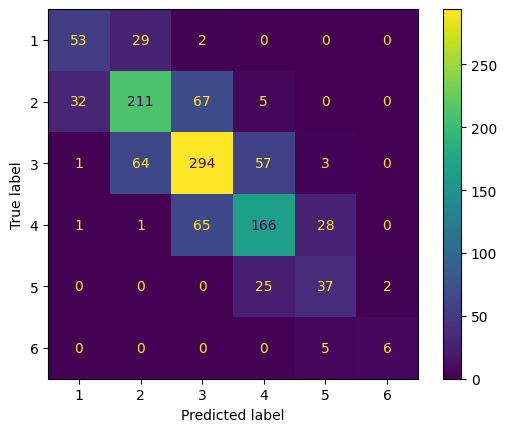

F1 score across fold: 0.6650344916613465
Cohen kappa score across fold: 0.8297169401129665
fold 8
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.831471	valid's QWK: 0.824473
[50]	train's QWK: 0.842163	valid's QWK: 0.831638
[75]	train's QWK: 0.847543	valid's QWK: 0.831455
[100]	train's QWK: 0.851682	valid's QWK: 0.834511
[125]	train's QWK: 0.855432	valid's QWK: 0.830951
[150]	train's QWK: 0.858406	valid's QWK: 0.833073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[175]	train's QWK: 0.862019	valid's QWK: 0.839327
[200]	train's QWK: 0.865245	valid's QWK: 0.837876
[225]	train's QWK: 0.867979	valid's QWK: 0.838906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[250]	train's QWK: 0.87128	valid's QWK: 0.838703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[275]	train's QWK: 0.874428	valid's QWK: 0.838801
Early stopping

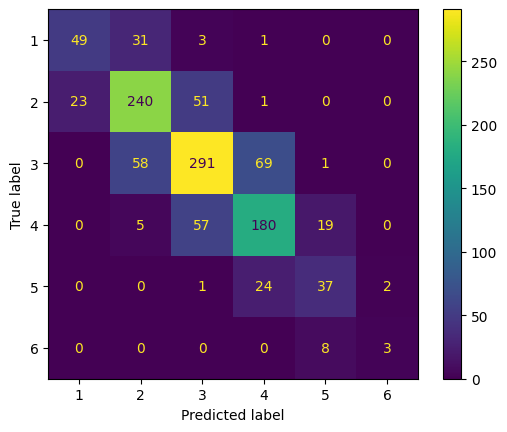

F1 score across fold: 0.6919791646085747
Cohen kappa score across fold: 0.8396178949035061
fold 9
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.830826	valid's QWK: 0.805938
[50]	train's QWK: 0.841859	valid's QWK: 0.816492
[75]	train's QWK: 0.84776	valid's QWK: 0.821801
[100]	train's QWK: 0.852477	valid's QWK: 0.826947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[125]	train's QWK: 0.856556	valid's QWK: 0.832379
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[150]	train's QWK: 0.861265	valid's QWK: 0.832479
[175]	train's QWK: 0.864637	valid's QWK: 0.830751
[200]	train's QWK: 0.867862	valid's QWK: 0.829811
Early stopping, best iteration is:
[129]	train's QWK: 0.857625	valid's QWK: 0.833328
Evaluated only: QWK


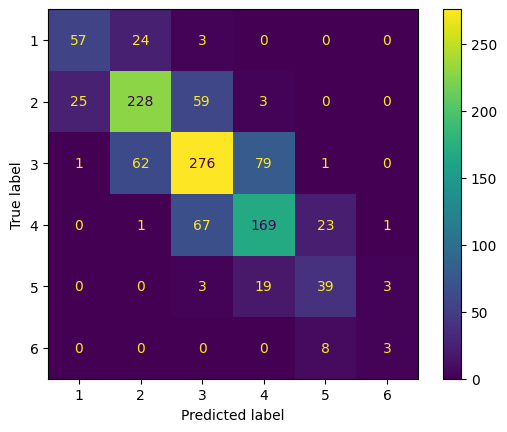

F1 score across fold: 0.6687976216575475
Cohen kappa score across fold: 0.8333284160995266
fold 10
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.828508	valid's QWK: 0.819429
[50]	train's QWK: 0.842067	valid's QWK: 0.82462
[75]	train's QWK: 0.847285	valid's QWK: 0.830764
[100]	train's QWK: 0.851943	valid's QWK: 0.833199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[125]	train's QWK: 0.856592	valid's QWK: 0.835811
[150]	train's QWK: 0.861165	valid's QWK: 0.836146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[175]	train's QWK: 0.864441	valid's QWK: 0.836943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	train's QWK: 0.866988	valid's QWK: 0.837235
[225]	train's QWK: 0.870639	valid's QWK: 0.837309
[250]	train's QWK: 0.873163	valid's QWK: 0.840728
[LightGBM] [Warning] No further splits with positive gain, best

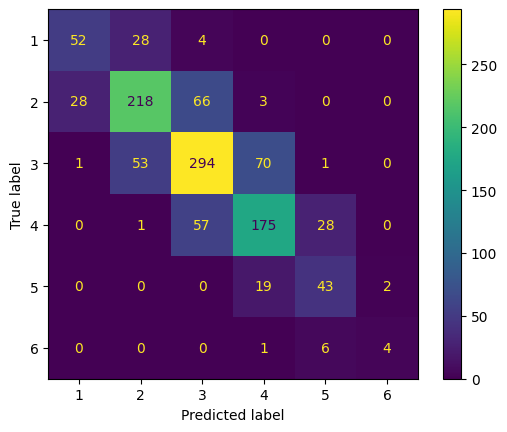

F1 score across fold: 0.6812685196738361
Cohen kappa score across fold: 0.8410550214500877
fold 11
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.830826	valid's QWK: 0.824295
[50]	train's QWK: 0.842625	valid's QWK: 0.838077
[75]	train's QWK: 0.84752	valid's QWK: 0.837842
[100]	train's QWK: 0.851781	valid's QWK: 0.839441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[125]	train's QWK: 0.855829	valid's QWK: 0.841355
[150]	train's QWK: 0.859566	valid's QWK: 0.836063
[175]	train's QWK: 0.863172	valid's QWK: 0.837721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	train's QWK: 0.867211	valid's QWK: 0.828929
Early stopping, best iteration is:
[126]	train's QWK: 0.856016	valid's QWK: 0.841801
Evaluated only: QWK


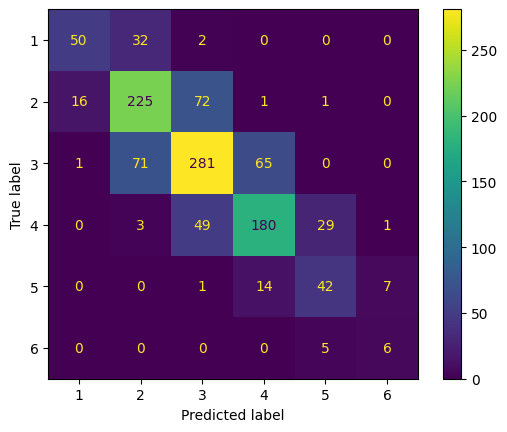

F1 score across fold: 0.6798893739401428
Cohen kappa score across fold: 0.8418008376902388
fold 12
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.828284	valid's QWK: 0.828624
[50]	train's QWK: 0.840625	valid's QWK: 0.831384
[75]	train's QWK: 0.846207	valid's QWK: 0.833613
[100]	train's QWK: 0.850574	valid's QWK: 0.832016
[125]	train's QWK: 0.854619	valid's QWK: 0.832394
Early stopping, best iteration is:
[72]	train's QWK: 0.845553	valid's QWK: 0.834619
Evaluated only: QWK


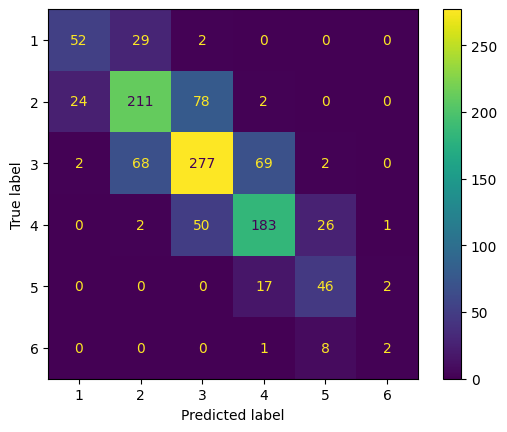

F1 score across fold: 0.6672439739881629
Cohen kappa score across fold: 0.8346190285630244
fold 13
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.829108	valid's QWK: 0.82148
[50]	train's QWK: 0.842012	valid's QWK: 0.824696
[75]	train's QWK: 0.847714	valid's QWK: 0.824507
[100]	train's QWK: 0.85169	valid's QWK: 0.824803
Early stopping, best iteration is:
[44]	train's QWK: 0.84039	valid's QWK: 0.826482
Evaluated only: QWK


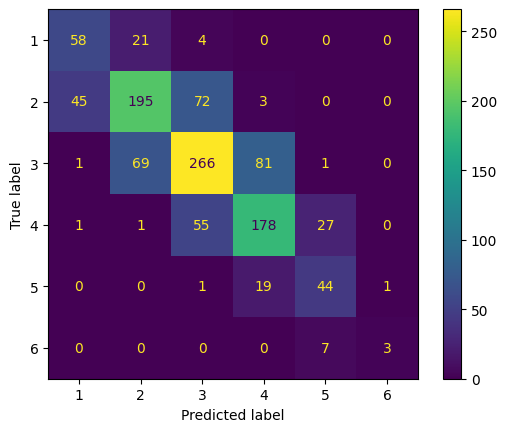

F1 score across fold: 0.6452049151383681
Cohen kappa score across fold: 0.8264822499217439
fold 14
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.82612	valid's QWK: 0.838373
[50]	train's QWK: 0.839238	valid's QWK: 0.8461
[75]	train's QWK: 0.845403	valid's QWK: 0.848259
[100]	train's QWK: 0.849518	valid's QWK: 0.846783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[125]	train's QWK: 0.852916	valid's QWK: 0.847093
[150]	train's QWK: 0.857269	valid's QWK: 0.844265
Early stopping, best iteration is:
[81]	train's QWK: 0.846486	valid's QWK: 0.848816
Evaluated only: QWK


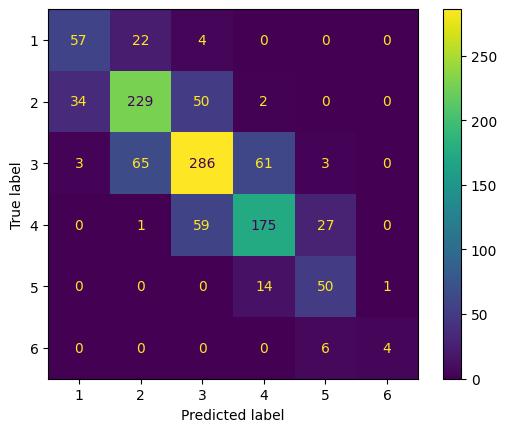

F1 score across fold: 0.6948555651127197
Cohen kappa score across fold: 0.8488155868945764
fold 15
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.82964	valid's QWK: 0.849419
[50]	train's QWK: 0.842198	valid's QWK: 0.854806
[75]	train's QWK: 0.847094	valid's QWK: 0.854461
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	train's QWK: 0.850975	valid's QWK: 0.850757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[125]	train's QWK: 0.854766	valid's QWK: 0.851407
Early stopping, best iteration is:
[50]	train's QWK: 0.842198	valid's QWK: 0.854806
Evaluated only: QWK


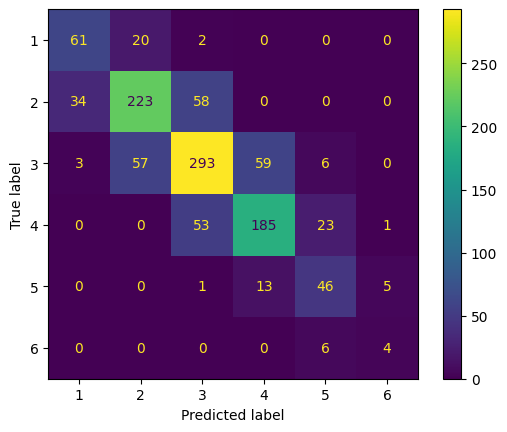

F1 score across fold: 0.7051445101047684
Cohen kappa score across fold: 0.8548061054738503
Mean F1 score across 15 folds: 0.6736113150753166
Mean Cohen kappa score across 15 folds: 0.8381868295421915


In [18]:
n_splits = 15

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

f1_scores = []
kappa_scores = []
models = []
predictions = []
callbacks = [log_evaluation(period=25), early_stopping(stopping_rounds=75,first_metric_only=True)]

i=1
for train_index, test_index in skf.split(X, y_split):
   
    print('fold',i)
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    
   
    y_train_fold, y_test_fold, y_test_fold_int = y[train_index], y[test_index], y_split[test_index]
    
    model = lgb.LGBMRegressor(
                objective = qwk_obj,
                metrics = 'None',
                learning_rate = 0.1,
                max_depth = 5,
                num_leaves = 10,
                colsample_bytree=0.5,
                reg_alpha = 0.1,
                reg_lambda = 0.8,
                n_estimators=1024,
                random_state=42,
                extra_trees=True,
                class_weight='balanced',
                verbosity = - 1)

    predictor = model.fit(X_train_fold,
                                  y_train_fold,
                                  eval_names=['train', 'valid'],
                                  eval_set=[(X_train_fold, y_train_fold), (X_test_fold, y_test_fold)],
                                  eval_metric=quadratic_weighted_kappa,
                                  callbacks=callbacks,)
    models.append(predictor)
    predictions_fold = predictor.predict(X_test_fold)
    predictions_fold = predictions_fold + a
    oof[test_index]=predictions_fold
    predictions_fold = predictions_fold.clip(1, 6).round()
    predictions.append(predictions_fold)
    f1_fold = f1_score(y_test_fold_int, predictions_fold, average='weighted')
    f1_scores.append(f1_fold)
    
    kappa_fold = cohen_kappa_score(y_test_fold_int, predictions_fold, weights='quadratic')
    kappa_scores.append(kappa_fold)
    
    cm = confusion_matrix(y_test_fold_int, predictions_fold, labels=[x for x in range(1,7)])

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[x for x in range(1,7)])
    disp.plot()
    plt.show()
    print(f'F1 score across fold: {f1_fold}')
    print(f'Cohen kappa score across fold: {kappa_fold}')
    i+=1

mean_f1_score = np.mean(f1_scores)
mean_kappa_score = np.mean(kappa_scores)

print(f'Mean F1 score across {n_splits} folds: {mean_f1_score}')
print(f'Mean Cohen kappa score across {n_splits} folds: {mean_kappa_score}')

In [19]:
# import pickle

# with open('models.pkl', 'wb') as f:
#     pickle.dump(models, f)

In [20]:
# with open('models.pkl', 'rb') as f:
#     models = pickle.load(f)

# **Inference**

In [21]:
# Paragraph
tmp = Paragraph_Preprocess(test)
test_feats = Paragraph_Eng(tmp)
# Sentence
tmp = Sentence_Preprocess(test)
test_feats = test_feats.merge(Sentence_Eng(tmp), on='essay_id', how='left')
# Word
tmp = Word_Preprocess(test)
test_feats = test_feats.merge(Word_Eng(tmp), on='essay_id', how='left')

# Tfidf
test_tfid = vectorizer.transform([i for i in test['full_text']])
dense_matrix = test_tfid.toarray()
df = pd.DataFrame(dense_matrix)
tfid_columns = [ f'tfid_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
df['essay_id'] = test_feats['essay_id']
test_feats = test_feats.merge(df, on='essay_id', how='left')

# CountVectorizer
test_tfid = vectorizer_cnt.transform([i for i in test['full_text']])
dense_matrix = test_tfid.toarray()
df = pd.DataFrame(dense_matrix)
tfid_columns = [ f'tfid_cnt_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
df['essay_id'] = test_feats['essay_id']
test_feats = test_feats.merge(df, on='essay_id', how='left')

# Meta Features(deberta-v3-large)
for i in range(6):
    test_feats[f'deberta_oof_{i}'] = predicted_score[:, i]

# Features number
feature_names = list(filter(lambda x: x not in ['essay_id','score'], test_feats.columns))
print('Features number: ',len(feature_names))
test_feats.head(3)

Features number:  27061


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,tfid_cnt_7355,tfid_cnt_7356,tfid_cnt_7357,tfid_cnt_7358,deberta_oof_0,deberta_oof_1,deberta_oof_2,deberta_oof_3,deberta_oof_4,deberta_oof_5
0,000d118,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0.005867,0.274048,0.693365,0.026059,0.000465,0.000196
1,000fe60,5,5,5,5,5,5,4,3,3,...,1,1,0,0,0.000463,0.034625,0.911631,0.052944,0.000277,0.000060
2,001ab80,4,4,4,4,4,4,4,4,4,...,0,0,0,0,0.000969,0.001600,0.018889,0.454450,0.515864,0.008228


In [22]:
probabilities = []
for model in models:
    proba= model.predict(test_feats[feature_names])+ a
    probabilities.append(proba)

predictions = np.mean(probabilities, axis=0)

predictions = np.round(predictions.clip(1, 6))

print(predictions)

[2. 3. 4.]


In [23]:
submission=pd.read_csv("/kaggle/input/learning-agency-lab-automated-essay-scoring-2/sample_submission.csv")
submission['score']=predictions
submission['score']=submission['score'].astype(int)
submission.to_csv("submission.csv",index=None)
display(submission.head())

,essay_id,score
0,000d118,2
1,000fe60,3
2,001ab80,4
